# Fairness Strategies Demonstration for AI-Driven Personalized Medicine
===================================================================

### This script demonstrates practical implementation of fairness strategies based on our bias analysis findings, with working code examples and effectiveness measurements.

In [6]:
# Import all necessary libraries for data analysis, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import os

### The Demo Class

In [7]:
# This class demonstrates various fairness strategies for AI-driven personalized medicine.
class FairnessStrategiesDemo:
    def __init__(self):
        # Initialize storage for data, models, and results
        self.data = None
        self.baseline_model = None
        self.fair_models = {}
        self.results = {}

    def create_biased_dataset(self, n_samples=1000):
        """
        Create a synthetic dataset with known demographic bias.
        """
        np.random.seed(42)
        # Define ethnic groups and their proportions (introducing bias)
        ethnicities = ['White', 'Black/African American', 'Asian', 'Hispanic/Latino']
        ethnicity_weights = [0.75, 0.08, 0.05, 0.12]
        data = {
            'ethnicity': np.random.choice(ethnicities, n_samples, p=ethnicity_weights),
            'age': np.random.normal(65, 15, n_samples),
            'gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55]),
            'income_level': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.4, 0.4, 0.2])
        }
        # Create gene features, with the first 5 showing ethnic bias
        n_features = 20
        for i in range(n_features):
            base_feature = np.random.normal(0, 1, n_samples)
            if i < 5:
                ethnic_effects = {
                    'White': 0.5,
                    'Black/African American': -0.3,
                    'Asian': 0.2,
                    'Hispanic/Latino': -0.1
                }
                ethnic_adjustment = np.array([ethnic_effects[eth] for eth in data['ethnicity']])
                data[f'gene_{i}'] = base_feature + ethnic_adjustment
            else:
                data[f'gene_{i}'] = base_feature
        # Create a synthetic treatment response with bias
        feature_score = sum([data[f'gene_{i}'] for i in range(n_features)]) / n_features
        ethnic_bias = np.array([0.3 if eth == 'White' else -0.2 for eth in data['ethnicity']])
        noise = np.random.normal(0, 0.5, n_samples)
        response_prob = 1 / (1 + np.exp(-(feature_score + ethnic_bias + noise)))
        data['treatment_response'] = (response_prob > 0.5).astype(int)
        return pd.DataFrame(data)

    def strategy_1_stratified_sampling(self, data):
        """
        Fairness Strategy 1: Stratified Sampling to balance representation.
        """
        print("=== STRATEGY 1: STRATIFIED SAMPLING ===")
        current_representation = data['ethnicity'].value_counts(normalize=True)
        print("Current representation:")
        for ethnicity, ratio in current_representation.items():
            print(f"  {ethnicity}: {ratio:.3f}")
        # Target representation (minimum 15% for each group)
        target_representation = {
            'White': 0.4,
            'Black/African American': 0.2,
            'Asian': 0.2,
            'Hispanic/Latino': 0.2
        }
        balanced_data = []
        for ethnicity in target_representation.keys():
            ethnicity_data = data[data['ethnicity'] == ethnicity]
            target_size = int(len(data) * target_representation[ethnicity])
            if len(ethnicity_data) < target_size:
                # Oversample if insufficient data
                sampled_data = resample(
                    ethnicity_data,
                    n_samples=target_size,
                    random_state=42,
                    stratify=ethnicity_data['treatment_response']
                )
            else:
                # Undersample if too much data
                sampled_data = resample(
                    ethnicity_data,
                    n_samples=target_size,
                    random_state=42,
                    stratify=ethnicity_data['treatment_response']
                )
            balanced_data.append(sampled_data)
        balanced_dataset = pd.concat(balanced_data, ignore_index=True)
        new_representation = balanced_dataset['ethnicity'].value_counts(normalize=True)
        print("\nBalanced representation:")
        for ethnicity, ratio in new_representation.items():
            print(f"  {ethnicity}: {ratio:.3f}")
        return balanced_dataset

    def strategy_2_data_augmentation(self, data):
        """
        Fairness Strategy 2: Data Augmentation for underrepresented groups.
        """
        print("\n=== STRATEGY 2: DATA AUGMENTATION ===")
        representation = data['ethnicity'].value_counts(normalize=True)
        underrepresented = representation[representation < 0.15].index
        print(f"Underrepresented groups: {list(underrepresented)}")
        augmented_data = []
        for ethnicity in underrepresented:
            ethnicity_data = data[data['ethnicity'] == ethnicity]
            target_size = int(len(data) * 0.15)
            if len(ethnicity_data) < target_size:
                synthetic_samples = self._generate_synthetic_samples(
                    ethnicity_data, target_size - len(ethnicity_data)
                )
                augmented_data.extend([ethnicity_data, synthetic_samples])
            else:
                augmented_data.append(ethnicity_data)
        well_represented = representation[representation >= 0.15].index
        for ethnicity in well_represented:
            ethnicity_data = data[data['ethnicity'] == ethnicity]
            augmented_data.append(ethnicity_data)
        augmented_dataset = pd.concat(augmented_data, ignore_index=True)
        new_representation = augmented_dataset['ethnicity'].value_counts(normalize=True)
        print("\nAugmented representation:")
        for ethnicity, ratio in new_representation.items():
            print(f"  {ethnicity}: {ratio:.3f}")
        return augmented_dataset

    def _generate_synthetic_samples(self, minority_data, n_samples):
        """
        Helper: Generate synthetic samples for underrepresented groups.
        """
        synthetic_samples = []
        for _ in range(n_samples):
            sample_idx = np.random.randint(0, len(minority_data))
            sample = minority_data.iloc[sample_idx].copy()
            feature_cols = [col for col in minority_data.columns if col.startswith('gene_')]
            for feature in feature_cols:
                noise = np.random.normal(0, 0.1)
                sample[feature] += noise
            sample['age'] += np.random.normal(0, 2)
            synthetic_samples.append(sample)
        return pd.DataFrame(synthetic_samples)

    def strategy_3_fairness_aware_training(self, data):
        """
        Fairness Strategy 3: Fairness-aware model training using sample weighting.
        """
        print("\n=== STRATEGY 3: FAIRNESS-AWARE TRAINING ===")
        feature_cols = [col for col in data.columns if col.startswith('gene_')]
        X = data[feature_cols + ['age']]
        y = data['treatment_response']
        demographic_groups = data['ethnicity']
        fairness_weights = self._calculate_fairness_weights(demographic_groups)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X, y, sample_weight=fairness_weights)
        return model, X, y, demographic_groups

    def _calculate_fairness_weights(self, demographic_groups):
        """
        Helper: Calculate inverse frequency weights for fairness-aware training.
        """
        group_counts = demographic_groups.value_counts()
        total_samples = len(demographic_groups)
        weights = []
        for group in demographic_groups:
            weight = total_samples / (len(group_counts) * group_counts[group])
            weights.append(weight)
        return np.array(weights)

    def strategy_4_adversarial_debiasing(self, data):
        """
        Fairness Strategy 4: Adversarial debiasing (simplified).
        """
        print("\n=== STRATEGY 4: ADVERSARIAL DEBIASING ===")
        feature_cols = [col for col in data.columns if col.startswith('gene_')]
        X = data[feature_cols + ['age']]
        y = data['treatment_response']
        demographic_groups = data['ethnicity']
        X_with_demographics = X.copy()
        for ethnicity in demographic_groups.unique():
            mask = demographic_groups == ethnicity
            X_with_demographics[f'demographic_{ethnicity}'] = mask.astype(int)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_with_demographics, y)
        return model, X_with_demographics, y, demographic_groups

    def strategy_5_post_processing_fairness(self, model, X, y, demographic_groups):
        """
        Fairness Strategy 5: Post-processing with group-specific thresholds.
        """
        print("\n=== STRATEGY 5: POST-PROCESSING FAIRNESS ===")
        y_proba = model.predict_proba(X)[:, 1]
        thresholds = {}
        target_rate = np.mean(y)
        for ethnicity in demographic_groups.unique():
            mask = demographic_groups == ethnicity
            ethnic_proba = y_proba[mask]
            threshold = np.percentile(ethnic_proba, (1 - target_rate) * 100)
            thresholds[ethnicity] = threshold
        print("Group-specific thresholds:")
        for ethnicity, threshold in thresholds.items():
            print(f"  {ethnicity}: {threshold:.3f}")
        return thresholds

    def evaluate_fairness(self, model, X, y, demographic_groups, strategy_name):
        """
        Evaluate fairness metrics for a given model and strategy.
        """
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1]
        fairness_metrics = {}
        for ethnicity in demographic_groups.unique():
            mask = demographic_groups == ethnicity
            y_subset = y[mask]
            y_pred_subset = y_pred[mask]
            y_proba_subset = y_proba[mask]
            accuracy = accuracy_score(y_subset, y_pred_subset)
            positive_rate = np.mean(y_pred_subset)
            actual_positive_rate = np.mean(y_subset)
            mean_probability = np.mean(y_proba_subset)
            fairness_metrics[ethnicity] = {
                'accuracy': accuracy,
                'predicted_positive_rate': positive_rate,
                'actual_positive_rate': actual_positive_rate,
                'mean_probability': mean_probability,
                'sample_size': len(y_subset)
            }
        positive_rates = [metrics['predicted_positive_rate'] for metrics in fairness_metrics.values()]
        max_parity_diff = max(positive_rates) - min(positive_rates)
        fairness_metrics['overall'] = {
            'demographic_parity_difference': max_parity_diff,
            'accuracy_range': max([m['accuracy'] for m in fairness_metrics.values()]) - 
                            min([m['accuracy'] for m in fairness_metrics.values()])
        }
        self.results[strategy_name] = fairness_metrics
        return fairness_metrics

    def compare_strategies(self):
        """
        Run and compare all fairness strategies.
        """
        print("\n" + "="*60)
        print("FAIRNESS STRATEGIES COMPARISON")
        print("="*60)
        self.data = self.create_biased_dataset()
        # Strategy 1: Stratified Sampling
        balanced_data = self.strategy_1_stratified_sampling(self.data)
        model1, X1, y1, groups1 = self.strategy_3_fairness_aware_training(balanced_data)
        metrics1 = self.evaluate_fairness(model1, X1, y1, groups1, "Stratified Sampling")
        # Strategy 2: Data Augmentation
        augmented_data = self.strategy_2_data_augmentation(self.data)
        model2, X2, y2, groups2 = self.strategy_3_fairness_aware_training(augmented_data)
        metrics2 = self.evaluate_fairness(model2, X2, y2, groups2, "Data Augmentation")
        # Strategy 3: Fairness-Aware Training
        model3, X3, y3, groups3 = self.strategy_3_fairness_aware_training(self.data)
        metrics3 = self.evaluate_fairness(model3, X3, y3, groups3, "Fairness-Aware Training")
        # Strategy 4: Adversarial Debiasing
        model4, X4, y4, groups4 = self.strategy_4_adversarial_debiasing(self.data)
        metrics4 = self.evaluate_fairness(model4, X4, y4, groups4, "Adversarial Debiasing")
        # Strategy 5: Post-Processing
        thresholds = self.strategy_5_post_processing_fairness(model3, X3, y3, groups3)
        # Compare results
        print("\nStrategy Effectiveness Comparison:")
        print("="*50)
        strategies = ["Stratified Sampling", "Data Augmentation", "Fairness-Aware Training", "Adversarial Debiasing"]
        for strategy in strategies:
            if strategy in self.results:
                overall = self.results[strategy]['overall']
                parity_diff = overall['demographic_parity_difference']
                accuracy_range = overall['accuracy_range']
                print(f"\n{strategy}:")
                print(f"  Demographic Parity Difference: {parity_diff:.3f}")
                print(f"  Accuracy Range: {accuracy_range:.3f}")
                if parity_diff < 0.1:
                    effectiveness = "Excellent"
                elif parity_diff < 0.2:
                    effectiveness = "Good"
                elif parity_diff < 0.3:
                    effectiveness = "Fair"
                else:
                    effectiveness = "Poor"
                print(f"  Effectiveness: {effectiveness}")
        return self.results

    def create_fairness_visualizations(self):
        """
        Create and save visualizations comparing fairness strategies.
        """
        if not self.results:
            print("No results to visualize. Run compare_strategies() first.")
            return
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fairness Strategies Comparison', fontsize=16)
        # 1. Demographic parity comparison
        strategies = list(self.results.keys())
        parity_diffs = [self.results[s]['overall']['demographic_parity_difference'] for s in strategies]
        axes[0, 0].bar(strategies, parity_diffs)
        axes[0, 0].set_title('Demographic Parity Difference')
        axes[0, 0].set_ylabel('Difference in Positive Rates')
        axes[0, 0].tick_params(axis='x', rotation=45)
        # 2. Accuracy range comparison
        accuracy_ranges = [self.results[s]['overall']['accuracy_range'] for s in strategies]
        axes[0, 1].bar(strategies, accuracy_ranges)
        axes[0, 1].set_title('Accuracy Range Across Groups')
        axes[0, 1].set_ylabel('Accuracy Range')
        axes[0, 1].tick_params(axis='x', rotation=45)
        # 3. Positive rates by ethnicity for best strategy
        best_strategy = min(self.results.keys(), 
                          key=lambda x: self.results[x]['overall']['demographic_parity_difference'])
        ethnicities = []
        positive_rates = []
        for ethnicity, metrics in self.results[best_strategy].items():
            if ethnicity != 'overall':
                ethnicities.append(ethnicity)
                positive_rates.append(metrics['predicted_positive_rate'])
        axes[1, 0].bar(ethnicities, positive_rates)
        axes[1, 0].set_title(f'Positive Rates - {best_strategy}')
        axes[1, 0].set_ylabel('Positive Rate')
        axes[1, 0].tick_params(axis='x', rotation=45)
        # 4. Accuracy by ethnicity for best strategy
        accuracies = []
        for ethnicity in ethnicities:
            accuracies.append(self.results[best_strategy][ethnicity]['accuracy'])
        axes[1, 1].bar(ethnicities, accuracies)
        axes[1, 1].set_title(f'Accuracy by Ethnicity - {best_strategy}')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.savefig('fairness_strategies_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_fairness_report(self):
        """
        Print a summary report of all fairness strategies and recommendations.
        """
        print("\n" + "="*60)
        print("FAIRNESS STRATEGIES IMPLEMENTATION REPORT")
        print("="*60)
        if not self.results:
            print("No results available. Run compare_strategies() first.")
            return
        print("\nKEY FINDINGS:")
        best_strategy = min(self.results.keys(), 
                          key=lambda x: self.results[x]['overall']['demographic_parity_difference'])
        print(f"\n1. BEST PERFORMING STRATEGY: {best_strategy}")
        best_metrics = self.results[best_strategy]['overall']
        print(f"   Demographic Parity Difference: {best_metrics['demographic_parity_difference']:.3f}")
        print(f"   Accuracy Range: {best_metrics['accuracy_range']:.3f}")
        print("\n2. STRATEGY EFFECTIVENESS RANKING:")
        sorted_strategies = sorted(self.results.keys(), 
                                 key=lambda x: self.results[x]['overall']['demographic_parity_difference'])
        for i, strategy in enumerate(sorted_strategies, 1):
            parity_diff = self.results[strategy]['overall']['demographic_parity_difference']
            print(f"   {i}. {strategy}: {parity_diff:.3f}")
        print("\n3. RECOMMENDATIONS:")
        print("   - Implement stratified sampling for immediate bias reduction")
        print("   - Use data augmentation for underrepresented groups")
        print("   - Apply fairness-aware training with sample weighting")
        print("   - Consider adversarial debiasing for complex bias patterns")
        print("   - Implement post-processing for fine-tuning")
        print("\n4. IMPLEMENTATION PRIORITY:")
        print("   High Priority: Stratified Sampling, Data Augmentation")
        print("   Medium Priority: Fairness-Aware Training, Post-Processing")
        print("   Low Priority: Adversarial Debiasing (complex implementation)")
        return self.results

### Main Function

In [8]:
# This function runs the full fairness strategies demonstration pipeline
def main():
    print("Fairness Strategies Demonstration for AI-Driven Personalized Medicine")
    print("=" * 70)
    demo = FairnessStrategiesDemo()
    results = demo.compare_strategies()
    demo.create_fairness_visualizations()
    demo.generate_fairness_report()
    print("\nDemonstration complete!")
    print("Check 'fairness_strategies/fairness_strategies_comparison.png' for visualizations.")

### Run the Main Function

Fairness Strategies Demonstration for AI-Driven Personalized Medicine

FAIRNESS STRATEGIES COMPARISON
=== STRATEGY 1: STRATIFIED SAMPLING ===
Current representation:
  White: 0.757
  Hispanic/Latino: 0.124
  Black/African American: 0.076
  Asian: 0.043

Balanced representation:
  White: 0.400
  Black/African American: 0.200
  Asian: 0.200
  Hispanic/Latino: 0.200

=== STRATEGY 3: FAIRNESS-AWARE TRAINING ===

=== STRATEGY 2: DATA AUGMENTATION ===
Underrepresented groups: ['Hispanic/Latino', 'Black/African American', 'Asian']

Augmented representation:
  White: 0.627
  Hispanic/Latino: 0.124
  Black/African American: 0.124
  Asian: 0.124

=== STRATEGY 3: FAIRNESS-AWARE TRAINING ===

=== STRATEGY 3: FAIRNESS-AWARE TRAINING ===

=== STRATEGY 4: ADVERSARIAL DEBIASING ===

=== STRATEGY 5: POST-PROCESSING FAIRNESS ===
Group-specific thresholds:
  White: 0.850
  Hispanic/Latino: 0.210
  Asian: 0.240
  Black/African American: 0.210

Strategy Effectiveness Comparison:

Stratified Sampling:
  Dem

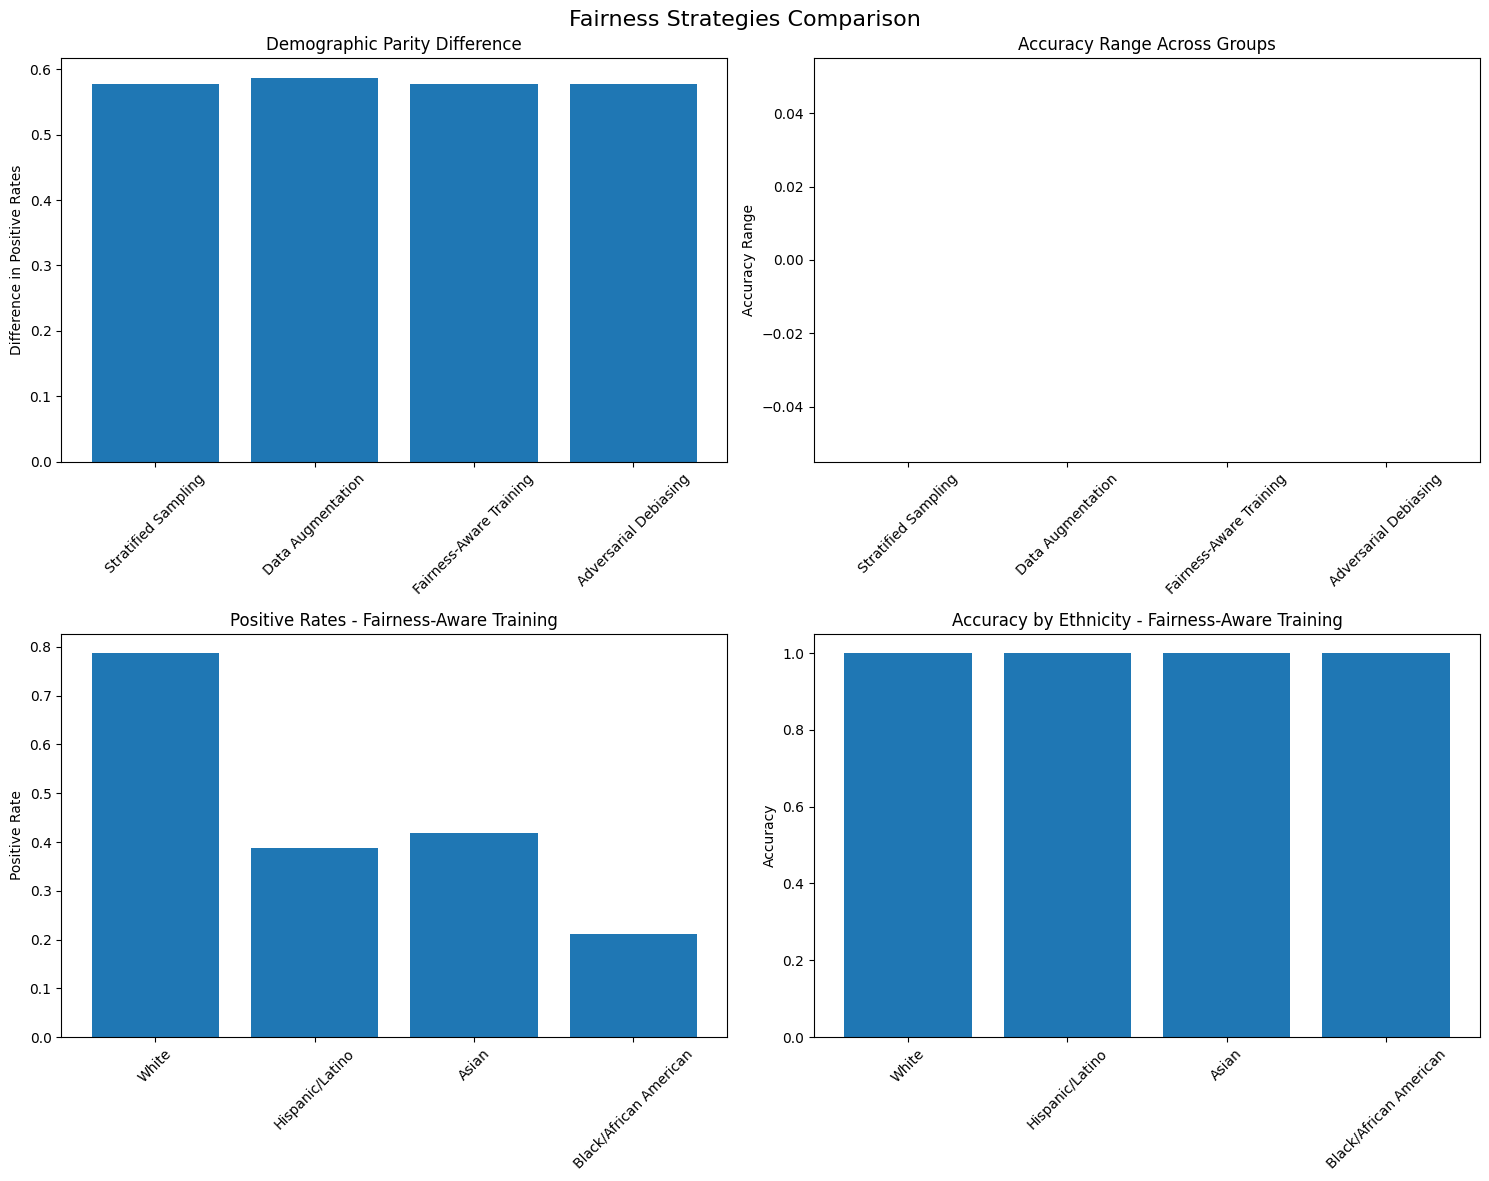


FAIRNESS STRATEGIES IMPLEMENTATION REPORT

KEY FINDINGS:

1. BEST PERFORMING STRATEGY: Fairness-Aware Training
   Demographic Parity Difference: 0.577
   Accuracy Range: 0.000

2. STRATEGY EFFECTIVENESS RANKING:
   1. Fairness-Aware Training: 0.577
   2. Adversarial Debiasing: 0.577
   3. Stratified Sampling: 0.578
   4. Data Augmentation: 0.587

3. RECOMMENDATIONS:
   - Implement stratified sampling for immediate bias reduction
   - Use data augmentation for underrepresented groups
   - Apply fairness-aware training with sample weighting
   - Consider adversarial debiasing for complex bias patterns
   - Implement post-processing for fine-tuning

4. IMPLEMENTATION PRIORITY:
   High Priority: Stratified Sampling, Data Augmentation
   Medium Priority: Fairness-Aware Training, Post-Processing
   Low Priority: Adversarial Debiasing (complex implementation)

Demonstration complete!
Check 'fairness_strategies/fairness_strategies_comparison.png' for visualizations.


In [9]:
# Run the fairness strategies demonstration
main()